In [2]:
import os
import numpy as np
import dask.array as da
import metpy.constants as mpconsts
import metpy.units as units
from func import cal_buoyancy  # import the function from your script
from pathlib import Path
import pandas as pd
from func import cal_buoyancy
from sklearn.metrics import mean_squared_error
import glob
import os
import re
import traceback
from scipy.interpolate import interp1d
import requests
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
from pydoc import help
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk

In [ ]:
backup_dir = Path.home() / "backup_data"

backup_dir.mkdir(parents=True, exist_ok=True)

# path to interpolated humidity, pressure, and temperature 

file_path_main_arrays = backup_dir / "backup_arrays_for_buoyancy.npz"

# path to times, latitudes and longitudes

file_path_metadata = backup_dir / "backup_metadata_for_buoyancy.npz"

data = np.load(file_path_main_arrays, mmap_mode='r')

print("file containing arrays loaded")

interpolated_pressure = data["array1"]

print("interpolated_pressure loaded") 

interpolated_q = data["array2"]

print("interpolated_q loaded") 

interpolated_t = data["array3"]

print("interpolated_t loaded")

interpolated_qfit = data["array_4"]

print("interpolated_qfit loaded") 

metadata = np.load(file_path_metadata)

times = metadata['times']

lats = metadata['lats']

lons = metadata['lons']

interpolated_altitudes = np.arange(0, 4000 + 20, 20)  

print("All arrays successfully loaded!")

In [19]:
lats = np.arange(39, 29.75, -0.25)   # 37 points from 39 to 30

lons = np.arange(-105, -94.75, 0.25) 

In [20]:
# Divide into 10 equal sections (10 edges means 11 bin edges)

lat_bins = np.linspace(lats.min(), lats.max(), 11)  

lon_bins = np.linspace(lons.min(), lons.max(), 11)

# Compute the center of each section

lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2

lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2

# Find the closest grid indices to these centers

lat_indices = [np.argmin(np.abs(lats - lc)) for lc in lat_centers]

lon_indices = [np.argmin(np.abs(lons - lc)) for lc in lon_centers]

selected_lats = lats[lat_indices]

selected_lons = lons[lon_indices]

selected_grid_points = [(lat, lon) for lat in selected_lats for lon in selected_lons]

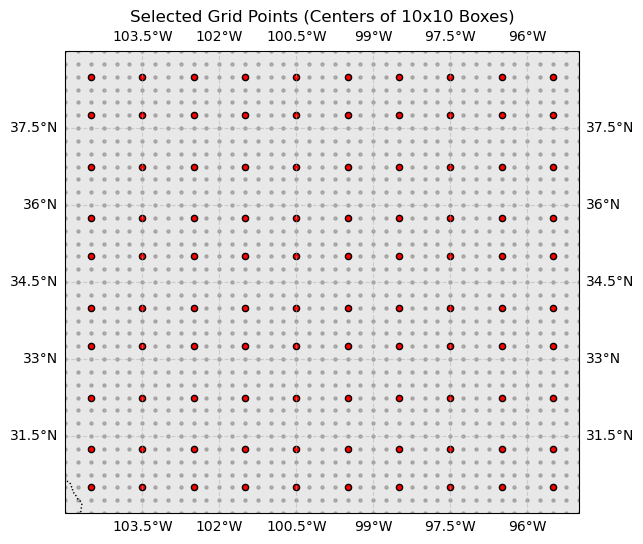

In [21]:
# Create the plot

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=1)

ax.add_feature(cfeature.BORDERS, linestyle=":")

ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.5)

ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.5)

# Plot the full grid
lon_grid, lat_grid = np.meshgrid(lons, lats)

ax.scatter(lon_grid, lat_grid, s=5, color="gray", alpha=0.5, transform=ccrs.PlateCarree(), label="Grid points")

# Plot the 100 selected grid points
for lat, lon in selected_grid_points:

    ax.scatter(lon, lat, color="red", s=20, marker="o", edgecolor="black", transform=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

plt.title("Selected Grid Points (Centers of 10x10 Boxes)")

plt.show()


In [15]:
interp_pres_small = interpolated_pressure[:, :, lat_indices, :][:, :, :, lon_indices]

interp_temp_small = interpolated_t[:, :, lat_indices, :][:, :, :, lon_indices]

interp_q_small = interpolated_q[:, :, lat_indices, :][:, :, :, lon_indices]

interp_qfit_small = interpolated_qfit[:, :, lat_indices, :][:, :, :, lon_indices]

lats_small = lats[lat_indices]

lons_small = lons[lon_indices]

In [21]:
# placing arrays in another folder for use

backup_dir = os.path.expanduser("~/limited_SGP_domain_arrays") 

os.makedirs(backup_dir, exist_ok=True)  # create the directory if it doesn't exist

file_path = os.path.join(backup_dir, "backup_arrays_for_buoyancy.npz")  # Full path to save file

np.savez_compressed(file_path, 
                    
                    interp_pres_small = interp_pres_small, 
                    
                    interp_temp_small = interp_temp_small, 
                    
                    interp_q_small = interp_q_small,
                    
                    interp_qfit_small = interp_qfit_small,
                    
                    lats_small = lats_small, 
                    
                    lons_small = lons_small, 
                    
                    times = times,
                    
                    interpolated_altitudes = interpolated_altitudes
                    
                   )

print(f"Arrays saved to {file_path}")

# Step 4: Verify that the file exists
print("Saved files:", os.listdir(backup_dir))

Arrays saved to /home/annierosen16/limited_SGP_domain_arrays/backup_arrays_for_buoyancy.npz
Saved files: ['backup_arrays_for_buoyancy.npz']
